## Importer des packages

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Charger le fichier de configuration

In [2]:
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dic']
dows = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']

In [3]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

## Création de moteur de connexion à la base de données

In [4]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Charger les données
Sélection des articles affiché après l'année 2018, publié (published=1).

In [5]:
df_articles = pd.read_sql_query("""SELECT art.id, art.title, art.primarykeyword as keyword, art.category, links.links, CAST(TO_CHAR(art.displaydate,'d') AS INTEGER) AS dow_display, EXTRACT(hour FROM art.displaydate) AS hour_display, EXTRACT(month FROM art.displaydate) AS month_display, CAST(EXTRACT(year FROM art.displaydate) AS VARCHAR) AS year_display, art.source, art.feed, conso.count as conso, chars.words, chars.characters, art.amountvideo AS videos, art.amountaudio AS audios, art.signature, art.title_url, keywords.nb_keywords FROM article_article art INNER JOIN article_nbchar.article_nbchar chars ON art.id = chars.mediaid INNER JOIN (SELECT article_id, SUM(count) AS count FROM egos_conso_article_per_day cs INNER JOIN article_article ar ON cs.article_id = ar.id WHERE cs.date >= ar.displaydate AND cs.date <= dateadd(day, 1, ar.displaydate) GROUP BY article_id) conso ON art.id = conso.article_id LEFT OUTER JOIN (SELECT articleid, COUNT(body) AS links FROM article_paragraph WHERE body LIKE '%%<a%%' GROUP BY articleid) links ON art.id = links.articleid LEFT OUTER JOIN (SELECT articleid, COUNT(keywordid) AS nb_keywords FROM article_article_keyword GROUP BY articleid) keywords ON art.id = keywords.articleid WHERE art.published='1' AND EXTRACT(year FROM art.displaydate) IN ('2018', '2019')""", engine)
df_articles.head()

id                                              title    keyword  \
0  4954463  Le mouvement pour l'éducation: l'ébauche d'un ...  POLITIQUE   
1  6086263      Les podcasts de Christine Hanquet à l'US Open     DIVERS   
2  7202963            Recette de Candice -  Spéculoos tendres     DIVERS   
3  7336093  Recette de Candice: Steak de lentilles et sala...     DIVERS   
4  7594383  Recette de Candice : Magret de canard séché ma...     DIVERS   

     category  links  dow_display  hour_display  month_display year_display  \
0     REGIONS    NaN            6            17              9         2018   
1      TENNIS    1.0            6            22              8         2019   
2  EN CUISINE    NaN            7             9             11         2019   
3  EN CUISINE    NaN            7            10              7         2019   
4  EN CUISINE    NaN            6            11             12         2019   

         source       feed  conso  words  characters  videos  audios  \
0  mgre@rtbf.be   RTBFINFO    104    240        1238       0       0   
1  damd@rtbf.be  RTBFSPORT    200     77         387       0       7   
2  ckot@rtbf.be   VIVACITE   2867    188         949       0       0   
3  ckot@rtbf.be   VIVACITE    168    175         870       0       0   
4  ckot@rtbf.be   VIVACITE    147    111         549       0       0   

           signature                                          title_url  \
0               RTBF  Le mouvement pour l'éducation: l'ébauche d'un ...   
1  Christine Hanquet      Les podcasts de Christine Hanquet à l'US Open   
2     Candice Kother  Recette de Candice -  Spéculoos sensuels (tend...   
3     Candice Kother  Recette de Candice: Steak de lentilles et sala...   
4            Candice  Recette de Candice : Magret de canard séché ma...   

   nb_keywords  
0          6.0  
1          3.0  
2          8.0  
3          7.0  
4          6.0

## Exploration des données

In [6]:
df_articles.shape

(140914, 19)

In [7]:
df_articles.columns

Index(['id', 'title', 'keyword', 'category', 'links', 'dow_display',
       'hour_display', 'month_display', 'year_display', 'source', 'feed',
       'conso', 'words', 'characters', 'videos', 'audios', 'signature',
       'title_url', 'nb_keywords'],
      dtype='object')

In [8]:
df_articles.head(10)

id                                              title    keyword  \
0  4954463  Le mouvement pour l'éducation: l'ébauche d'un ...  POLITIQUE   
1  6086263      Les podcasts de Christine Hanquet à l'US Open     DIVERS   
2  7202963            Recette de Candice -  Spéculoos tendres     DIVERS   
3  7336093  Recette de Candice: Steak de lentilles et sala...     DIVERS   
4  7594383  Recette de Candice : Magret de canard séché ma...     DIVERS   
5  7769906  Recette de Candice: Nouilles aux scampis caram...     DIVERS   
6  7788263  Recette de Candice : Poulet au curcuma et au g...     DIVERS   
7  7836181  Participez aux prochains enregistrements des E...     DIVERS   
8  7841358          Le zéro déchet en cuisine, c'est facile!      DIVERS   
9  7855323                Ecosse-Belgique, histoire d'un duel     DIVERS   

                category  links  dow_display  hour_display  month_display  \
0                REGIONS    NaN            6            17              9   
1                 TENNIS    1.0            6            22              8   
2             EN CUISINE    NaN            7             9             11   
3             EN CUISINE    NaN            7            10              7   
4             EN CUISINE    NaN            6            11             12   
5             EN CUISINE    NaN            7             9             11   
6          QUOI DE NEUF?    NaN            5            16             11   
7  LES ENFANTS DE CHOEUR    NaN            7            12              3   
8        BIENTOT A TABLE    NaN            7            11              9   
9               FOOTBALL    4.0            5             7              9   

  year_display        source        feed  conso  words  characters  videos  \
0         2018  mgre@rtbf.be    RTBFINFO    104    240        1238       0   
1         2019  damd@rtbf.be   RTBFSPORT    200     77         387       0   
2         2019  ckot@rtbf.be    VIVACITE   2867    188         949       0   
3         2019  ckot@rtbf.be    VIVACITE    168    175         870       0   
4         2019  ckot@rtbf.be    VIVACITE    147    111         549       0   
5         2018  ahou@rtbf.be    VIVACITE    727    197        1005       0   
6         2018  ckot@rtbf.be    VIVACITE     76    126         666       0   
7         2019  mipa@rtbf.be    VIVACITE     36    100         603       0   
8         2019  msop@rtbf.be  LAPREMIERE     15    704        3676       0   
9         2018  syro@rtbf.be   RTBFSPORT   1722   3613       20093      13   

   audios              signature  \
0       0                   RTBF   
1       7      Christine Hanquet   
2       0         Candice Kother   
3       0         Candice Kother   
4       0                Candice   
5       0                Candice   
6       0                Candice   
7       0  Les Enfants de Choeur   
8       0                   bat    
9       0             S. Rouquet   

                                           title_url  nb_keywords  
0  Le mouvement pour l'éducation: l'ébauche d'un ...          6.0  
1      Les podcasts de Christine Hanquet à l'US Open          3.0  
2  Recette de Candice -  Spéculoos sensuels (tend...          8.0  
3  Recette de Candice: Steak de lentilles et sala...          7.0  
4  Recette de Candice : Magret de canard séché ma...          6.0  
5  Recette de Candice: Nouilles aux scampis caram...         10.0  
6  Recette de Candice : Poulet au curcuma et au g...          8.0  
7  Participez aux prochains enregistrements des E...          5.0  
8  Emission du samedi 22.09.2012 - Cette semaine,...          2.0  
9                Belgique-Ecosse, histoire d'un duel          4.0

In [9]:
df_articles.describe()

id         links    dow_display   hour_display  \
count  1.409140e+05  10264.000000  140914.000000  140914.000000   
mean   1.009319e+07      1.497467       4.007153      13.277417   
std    1.781614e+05      1.514036       1.776672       4.453786   
min    4.954463e+06      1.000000       1.000000       0.000000   
25%    9.946316e+06      1.000000       3.000000      10.000000   
50%    1.008904e+07      1.000000       4.000000      13.000000   
75%    1.024034e+07      1.000000       6.000000      17.000000   
max    1.039826e+07     59.000000       7.000000      23.000000   

       month_display          conso          words     characters  \
count  140914.000000  140914.000000  140914.000000  140914.000000   
mean        6.445123     791.123309     309.598031    1611.987595   
std         3.360482    2465.497096     225.891449    1177.336816   
min         1.000000       1.000000       0.000000       0.000000   
25%         3.000000      40.000000     164.000000     851.000000   
50%         6.000000     169.000000     260.000000    1347.000000   
75%         9.000000     616.000000     393.000000    2056.000000   
max        12.000000  268581.000000    8250.000000   43976.000000   

              videos         audios    nb_keywords  
count  140914.000000  140914.000000  140741.000000  
mean        0.660992       0.091141       4.629731  
std         1.066775       0.409177       2.672818  
min         0.000000       0.000000       1.000000  
25%         0.000000       0.000000       3.000000  
50%         0.000000       0.000000       4.000000  
75%         1.000000       0.000000       6.000000  
max        41.000000      23.000000     172.000000

In [10]:
df_articles.isnull().any()

id               False
title            False
keyword           True
category         False
links             True
dow_display      False
hour_display     False
month_display    False
year_display     False
source           False
feed             False
conso            False
words            False
characters       False
videos           False
audios           False
signature        False
title_url        False
nb_keywords       True
dtype: bool

In [11]:
df_articles['weekday'] = df_articles['dow_display'].apply(lambda x: 'week' if x > 1 and x < 7 else 'weekend')
#df_articles['month_display'] = df_articles['month_display'].apply(lambda x: months[x-1])
#df_articles['dow_display'] = df_articles['dow_display'].apply(lambda x: dows[x-1])
df_articles['url_title'] = df_articles['title_url'].apply(lambda x: x.split(':')[0] if ':' in x else '')
df_articles['depeche'] = df_articles['signature'].apply(lambda x: 1 if True in [w.lower().strip() in ['belga', 'afp'] for w in x.split(' ')] else 0)
df_articles['videos'] = df_articles['videos'].apply(lambda x: 0 if np.isnan(x) else 1)
df_articles['audios'] = df_articles['audios'].apply(lambda x: 0 if np.isnan(x) else 1)
df_articles['title_length'] = df_articles['title'].apply(lambda x: len(x))
df_articles['links'] = df_articles['links'].apply(lambda x: x if x == x else 0)
df_articles['nb_keywords'] = df_articles['nb_keywords'].apply(lambda x: x if x == x else 0)
#df_articles['links'] = df_articles['links'].apply(lambda x: 1 if x > 0 else 0)

## Identification des variables

In [12]:
ID_col = ['id']
target_col = ['conso']
cat_cols = ['category', 'source', 'feed', 'keyword', 'signature', 'depeche', 'url_title', 'weekday']
ord_cols = ['words', 'characters', 'month_display', 'videos', 'audios', 'dow_display', 'title_length', 'hour_display', 'links', 'nb_keywords']
other_cols = []
features = cat_cols.copy()
features.extend(ord_cols)
features.extend(other_cols)

In [13]:
cat_lists = []
for cat in cat_cols:
    cat_lists.append(df_articles[cat].unique())
cat_lists

[array(['REGIONS', 'TENNIS', 'EN CUISINE', 'QUOI DE NEUF?',
        'LES ENFANTS DE CHOEUR', 'BIENTOT A TABLE', 'FOOTBALL', 'TV',
        'DECO', 'BELGIQUE', 'DICOMMUNALES', 'SPORT', 'MOTEURS', 'CYCLISME',
        'BEAUTE', 'BIEN-ETRE', 'CUISINE', 'ANIMATEUR', 'VOYAGES',
        'VIVA FOR LIFE', 'DIY', 'PAR DELA LES ONDES', 'PSYCHO',
        'COMPLETEMENT FOOT', 'SANTE', 'DETENTE', 'MODE',
        'LE BEAU VELO DE RAVEL', 'ENTREZ SANS FRAPPER', 'MONDE',
        'MATIN PREMIERE', 'HOME', 'PROVISOIRE', 'ZAPPING 21', 'VOYAGE',
        'HAINAUT MATIN', 'FLASHBACK', 'TODAY IN MUSIC', 'TECHNO',
        'UN JOUR DANS L HISTOIRE', 'NEWS', 'TENDANCES PREMIERE',
        'TRANSVERSALES', 'SCENES', 'LES CLASSIQUES', 'LIEGE MATIN',
        'LE 8 9', 'VIVACITE WEEK-END', 'JOURNAL DU ROCK', 'SOCIETE',
        'PAR OUI DIRE', 'VIVACITE EN CONCERT', 'JE SAIS PAS VOUS',
        'ACTUALITE', 'SURFONS TRANQUILLE', 'MEV', 'A PORTEE DE MOTS',
        'MAKING OF', 'FOOD 21', 'AVIS DE RECHERCHE', 'HIGH TECH',

# Transformation des données

## Traiter les valeurs manquantes

### 1. Supprimer les enregistrements sans informations de consommation

In [14]:
df_articles = df_articles[~df_articles['conso'].isna()]
df_articles.shape

(140914, 23)

### 2. Supprimer les enregistrements sans informations de nombre des mots

In [15]:
df_articles = df_articles[~df_articles['characters'].isna()]
df_articles = df_articles[~df_articles['words'].isna()]
df_articles.shape

(140914, 23)

In [16]:
df_articles = df_articles[~df_articles['keyword'].isna()]
df_articles.shape

(139818, 23)

In [17]:
df_articles.isnull().any()

id               False
title            False
keyword          False
category         False
links            False
dow_display      False
hour_display     False
month_display    False
year_display     False
source           False
feed             False
conso            False
words            False
characters       False
videos           False
audios           False
signature        False
title_url        False
nb_keywords      False
weekday          False
url_title        False
depeche          False
title_length     False
dtype: bool

In [18]:
df_articles.describe()

id          links    dow_display   hour_display  \
count  1.398180e+05  139818.000000  139818.000000  139818.000000   
mean   1.009345e+07       0.109929       4.007417      13.268270   
std    1.784189e+05       0.566386       1.777562       4.453198   
min    4.954463e+06       0.000000       1.000000       0.000000   
25%    9.946338e+06       0.000000       3.000000      10.000000   
50%    1.008918e+07       0.000000       4.000000      13.000000   
75%    1.024101e+07       0.000000       6.000000      16.000000   
max    1.039826e+07      59.000000       7.000000      23.000000   

       month_display          conso          words     characters    videos  \
count  139818.000000  139818.000000  139818.000000  139818.000000  139818.0   
mean        6.449871     796.783511     311.351285    1621.102326       1.0   
std         3.360570    2474.301207     225.783806    1176.474155       0.0   
min         1.000000       1.000000       0.000000       0.000000       1.0   
25%         3.000000      40.000000     166.000000     863.000000       1.0   
50%         6.000000     172.000000     261.000000    1355.000000       1.0   
75%         9.000000     622.000000     395.000000    2063.000000       1.0   
max        12.000000  268581.000000    8250.000000   43976.000000       1.0   

         audios    nb_keywords        depeche   title_length  
count  139818.0  139818.000000  139818.000000  139818.000000  
mean        1.0       4.652455       0.394077      67.173104  
std         0.0       2.667180       0.488653      19.924481  
min         1.0       0.000000       0.000000       4.000000  
25%         1.0       3.000000       0.000000      54.000000  
50%         1.0       4.000000       0.000000      68.000000  
75%         1.0       6.000000       1.000000      81.000000  
max         1.0     172.000000       1.000000     254.000000

## Définition de preprocessing

In [19]:
ord_transformer = preprocessing.PowerTransformer()
scaler_transformer = preprocessing.MinMaxScaler()
cat_transformer = preprocessing.OneHotEncoder(categories=cat_lists)
preprocessor = make_column_transformer(
    (ord_transformer, ord_cols),
    (scaler_transformer, other_cols),
    (cat_transformer, cat_cols)
)

## Séparation de données: test et de train

In [52]:
y = df_articles.conso
x = df_articles[features]

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

## Prédict

In [54]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=linear_model.HuberRegressor(epsilon=1, max_iter=500000),#.Ridge(alpha=1e-10), #KNeighborsRegressor(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )  
)

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
s_mean = np.mean(scores)
print('Mean MAE: %.3f' % (s_mean))

In [22]:
pd.DataFrame({'pred': y_pred, 'test': y_test}).plot.scatter(x='pred', y='test')

In [ ]:
print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
results = x_test.copy()
results['y'] = y_test
results['y_pred'] = y_pred
results.to_csv('{}_results.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')))

/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


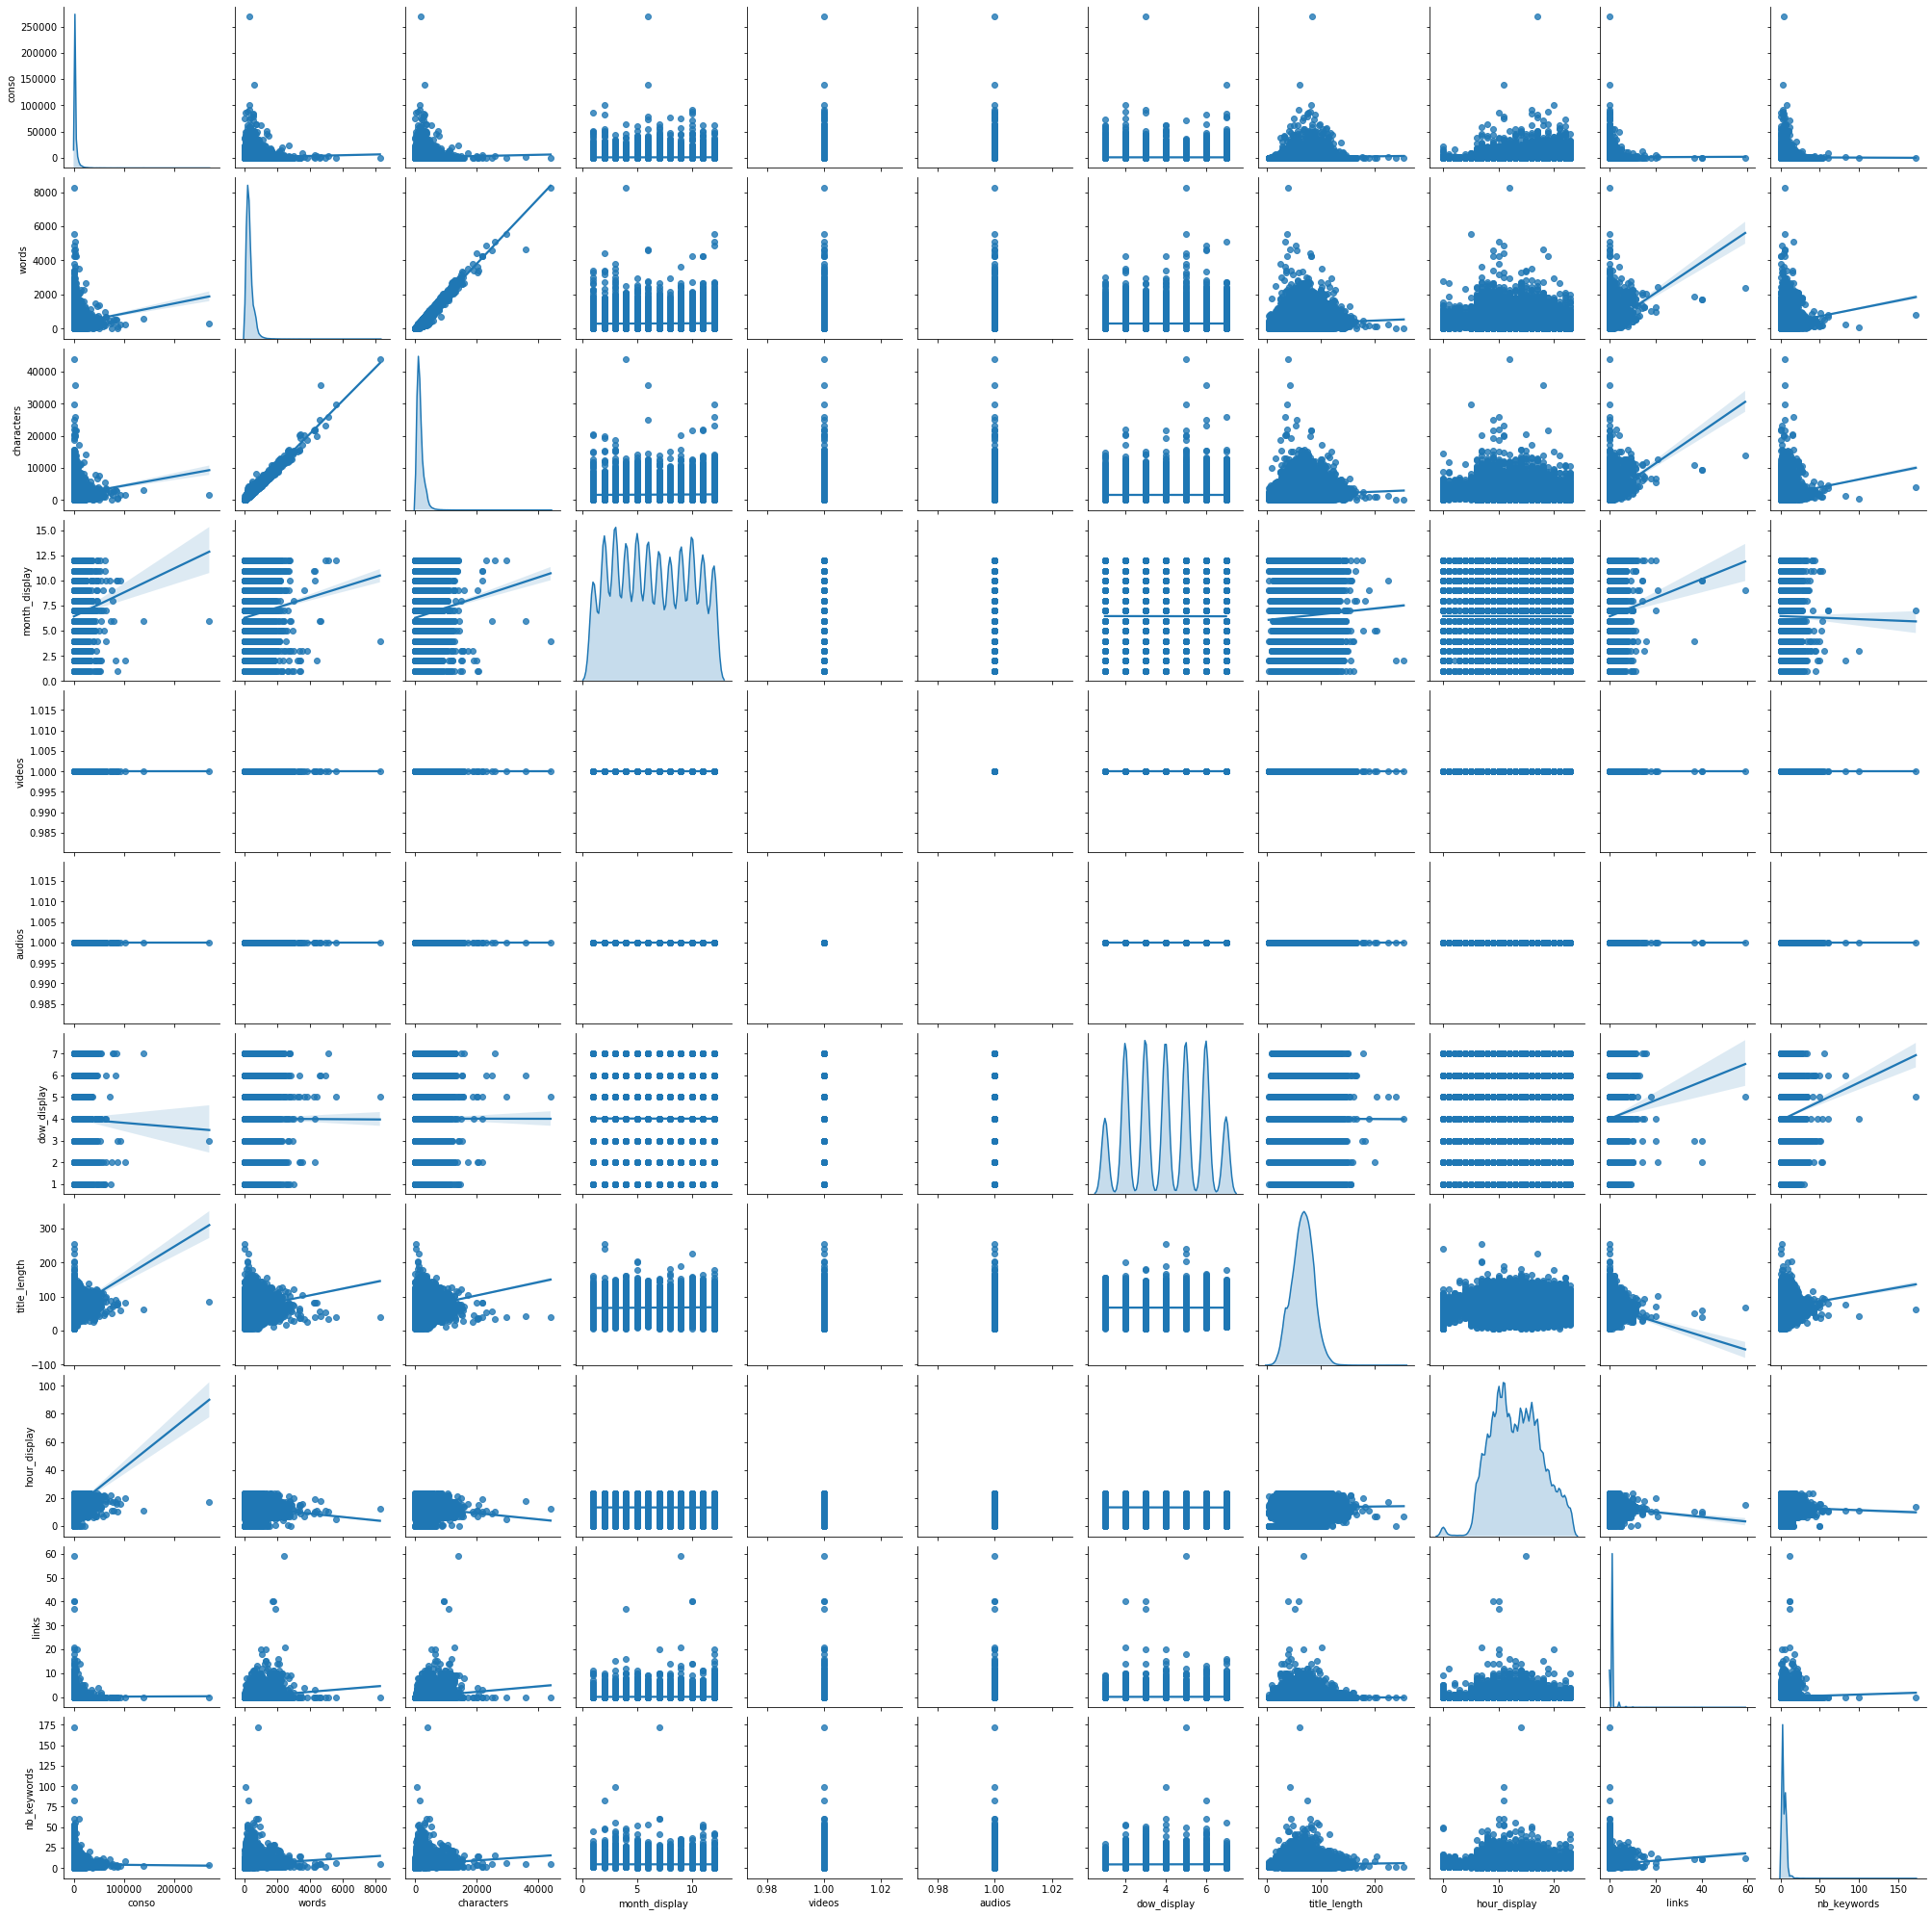

In [20]:
_ = sns.pairplot(df_articles[['conso', *other_cols, *ord_cols]], kind='scatter', diag_kind='kde')

/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


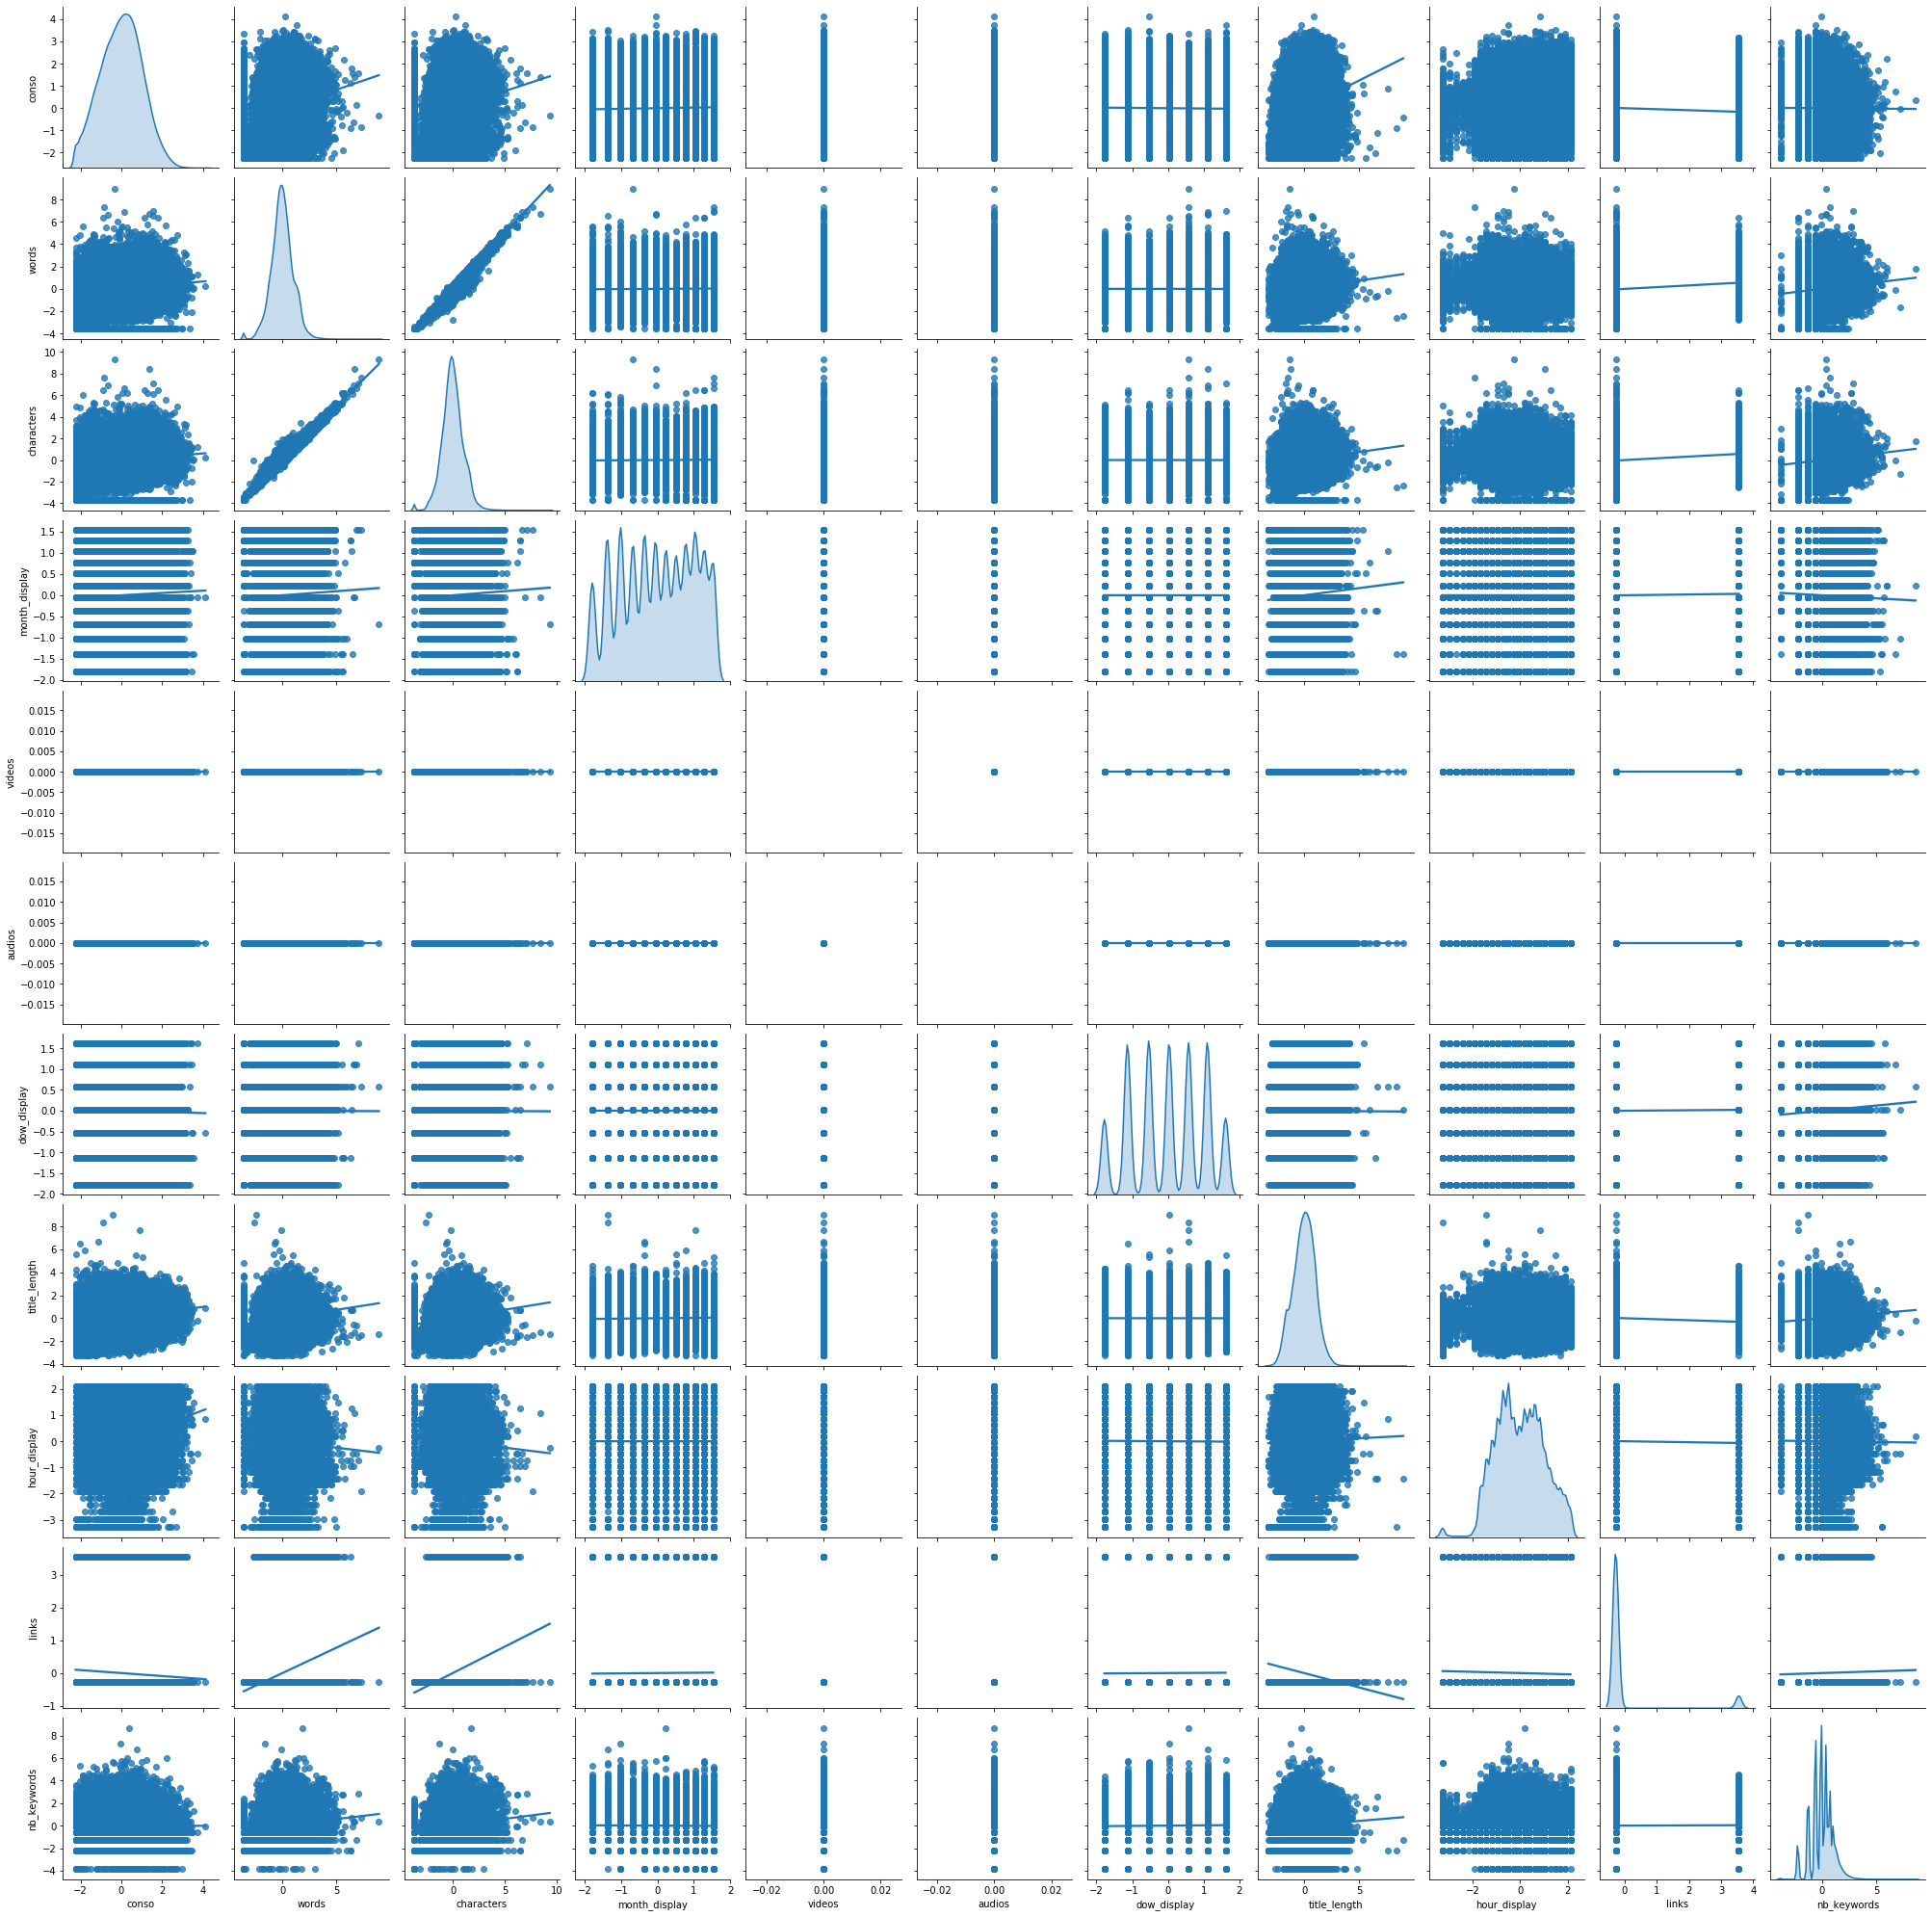

In [21]:
tmp = pd.DataFrame(ord_transformer.fit_transform(df_articles[['conso', *ord_cols]]), columns=['conso', *ord_cols])
for col in other_cols:
    tmp[col] = scaler_transformer.fit_transform(df_articles[[col]])
_ = sns.pairplot(tmp, kind='scatter', diag_kind='kde')

In [ ]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=cat_cols))
feature_names = np.concatenate(
    [feature_names, ord_cols, other_cols])

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)

coefs

In [ ]:
coefs['abs_coef'] = coefs['Coefficients'].apply(lambda x: abs(x))

In [ ]:
coefs[coefs['abs_coef'] > 0.6][['Coefficients']].plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [ ]:
pd.read_sql_query("""SELECT * from egos_conso_article_connected_user limit 1""", engine).columns

In [ ]:
df_network = pd.read_sql_query("""SELECT detail.uid, art.id AS art_id, art.feed, EXTRACT(month FROM detail.date) AS month, EXTRACT(year FROM detail.date) AS year, COUNT(detail.date) FROM egos_conso_article_connected_user detail INNER JOIN article_article art ON art.id = detail.article_id WHERE date >= '2019-07-01'""", engine)
df_network.head()

In [ ]:
df_nod_art =  